In [46]:
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import emoji
import re
import string
import pickle

Let's get some dirt on our hands. Part of the preprocessing work that must be done is cleaning the data, and preparing it from the model. Here we received a twitter (now called x) dataset comments including messages categorized into three classes: Positive, Negative, and Neutral. Messages that are not relevant to the entity are considered Neutral. The goal is to judge the sentiment of the message regarding the specified entity.

This dataset might be found in [here!](https://huggingface.co/datasets/yogiyulianto/twitter-sentiment-dataset-en).

At first, we clean the data and pre-visualize some rows.

In [72]:
zip_path = './media/datasets/archive.zip'
extract_dir = './media/datasets/csv/'
vocabulary_dir = './media/vocabulary/'
models_dir = './media/models/'

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_dir)

dataframe_train = pd.read_csv(extract_dir+'twitter_training.csv', names=['ID','user','SC','Comment'])
dataframe_test = pd.read_csv(extract_dir+'twitter_validation.csv', names=['ID','user','SC','Comment'])

The data looks as follows:

In [15]:
dataframe_train.iloc[1250:1257]

,ID,user,SC,Comment
1250,2619,Borderlands,Positive,i maed dis bc i love maya (the siren) and im v...
1251,2619,Borderlands,Positive,i do dis bc i am maya (the siren) and im very ...
1252,2619,Borderlands,Positive,i maed is dis bc i love maya ( the siren ) and...
1253,2619,Borderlands,Positive,i maed dis bc i love the (the beautiful) girl ...
1254,2620,Borderlands,Positive,A reimagining of the Keep on the Borderlands. ...
1255,2620,Borderlands,Positive,And he also makes the caves of chaos! This stu...
1256,2620,Borderlands,Positive,"And he's also doing ""The Eagles""! This stuff w..."


So, we can start categorizing the data frames by positive and negative categories for now. In a next proposal, would it be good idea to perform a classification 
including not binary outputs but more aleatory categorization. Additionally, we drop unnecessary columns such as 'ID','user'.

In [18]:
def dropRowValue(dataframe,column,values):
    return dataframe[~dataframe[column].isin(values)]

def sentimentFilter(sentence, category):
    """
    By default the category entered to the sentimentFilter function will be transformed to 1
    """
    sentiment_num_list = []
    for sentiment in sentence:
        if sentiment == category:
            sentiment_num_list.append(1)
        else:
            sentiment_num_list.append(0)
    return sentiment_num_list

# training
filter_dataframe_train = dropRowValue(dataframe_train,'SC',['Neutral','Irrelevant']).drop(['ID','user'], axis=1)
list_x_train = filter_dataframe_train['Comment'].to_list()
list_y_train = filter_dataframe_train['SC'].to_list()
y_train = sentimentFilter(list_y_train,'Positive')

# testing
filter_dataframe_test = dropRowValue(dataframe_test,'SC',['Neutral','Irrelevant']).drop(['ID','user'], axis=1)
list_x_test = filter_dataframe_test['Comment'].to_list()
list_y_test = filter_dataframe_test['SC'].to_list()
y_test = sentimentFilter(list_y_test,'Positive')

I do believe there is a huge importance in the emojis significance in daily dialectic where 59% of consumers aged 18-34 believe companies use too many emojis. 51% of survey respondents said they're likely to engage with a brand's posts if they include emojis. 63% of people think positive emoji usage increases your credibility. 92% of online consumers use emojis every day.

Here I introduce the emoji MASK. Basically, adding a MASK strategy as used in tensors to the emojis over all the training data for improving the accuracy. Doing so, the data will not perceive the unicode text but the emotion text which is given by the emoji translation to text expression. There are another approached to this same problematic such as training the model for identifying the emoji and converting it into an emotion which might be interesting. Nevertheless, the idea is generating the less time complex simple model for solving this issue with the help of python. 

This remembers me once at sentiment analysis competition at UTRGV. Our team decided to go for BERT sentiment analysis strategy which lead to a high computational effort. On the other hand, one of our competitors, whom finally win by 2% more accuracy used statistical approach using hyperparameter tunning using GridSearchCV which was ~70% less computational complex than running a pre-trained LLM model by ~60% less time investment. 

In [41]:
def emojiMask(sentence):
    sentenceEmojiMask = emoji.replace_emoji(sentence,
                        replace=lambda chars,
                        data_dict: chars.encode('ascii', 'namereplace').decode())
    return sentenceEmojiMask


x_train_emojimask = [emojiMask(str(row)) for row in list_x_train]
x_test_emojimask = [emojiMask(str(row)) for row in list_x_test]

On Tensorflow, the inputs in the model might be set-up before. Using the pre-loaded models from tensorflow datasets it is quite easier running a model because of the tensors structure is already configure for this purpose. Here, I decided to transform all data into lists, and from lists to tensors.

Additionally, we prepare the datasets for training and testing the final model. The `shuffle` function randomizes the dataset to prevent the model from learning the order of the data. The `batch` function divides the shuffled dataset into batches, improving training speed and efficiency by allowing the model to process multiple samples at once, and the `prefetch` function prefetches data to overlap preprocessing and model execution, reducing training time.

In [44]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# tensor vector for model
def trainTensorSlice(xlist,ylist):
    x_tensor = tf.constant(xlist)
    y_tensor = tf.constant(ylist)
    dataset_tensor = tf.data.Dataset.from_tensor_slices((x_tensor,y_tensor)) # no batching, the batching will be later on
    return dataset_tensor

train_ds = trainTensorSlice(x_train_emojimask,y_train)
test_ds = trainTensorSlice(x_test_emojimask,y_test)


train_dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I started using the simplest model found on Tensorflow website, specifically the [issue](https://github.com/tensorflow/text/issues/174) were there is a description about the creation of a vocabulary using `tf.lookup.KeyValueTensorInitializer`. Then I realized that if the tokenization needs are simple and the vocabulary is small and static, the approach using `StaticVocabularyTable` can work efficiently. However, there are more complex tokenization needs or dynamic vocabularies, using a higher-level API like `TextVectorization` a text encoder might be more appropriate. These higher-level APIs offer more flexibility and are easier to integrate into TensorFlow models, making them suitable for a wider range of tokenization tasks.

Although, I highly encourage to use the `tf.lookup.KeyValueTensorInitializer` which provides a deep insight about Tensorflow models.

In [66]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 100

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            output_mode='int',
                                            output_sequence_length=SEQUENCE_LENGTH)


encoder.adapt(train_dataset.map(lambda text, label: text))
vocabulary = np.array(encoder.get_vocabulary())

2024-04-24 23:26:15.303906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]
2024-04-24 23:26:15.304465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]


### start example

Generate a vocabulary out of the training dataset and de-gerenate it

In [49]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'The dreamcast days! Congrats David'
 b'@NBA2K_MyTEAM D @NBA2K @2K I purchased that something from just you, and never received and your customer service says such its not their chief problem. Do or i need to immediately contact the better business bureau? This crap is ridiculous'
 b'2014 Very Interesting video.' b'This is just freakin rad!'
 b"@JeffBezos Must be be feeling the mental pain instead of making his quick divorce. If you cannot deliver what you promise, don't promise to deliver... Do you back your word, or not? Well I expected a nice package that I needed. Amazon admitted quickly that it was their own fault, not the anonymous seller's... Why am I paying a subscription?"
 b'@amazon probably some of the worst customer computer service I \xe2\x80\x99 ve had you to properly deal with lately'
 b'why Beth does like every man in borderlands have she slicked that back hair haven \xe2\x80\x99 t you heard enough of gray bangs you stupid assholes'
 b'is unheard of, honestly. 

2024-04-24 23:17:48.958920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]
2024-04-24 23:17:48.959448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]


In [50]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1, 240,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [731, 563, 125, 330,   3,   1,  16, 218,  36,  23,  14,   5, 126,
        763,   5,  33, 509, 304, 454, 247,  31,  22, 106,   1, 272,  43,
         66,   3, 198,   4,   1,   1,   2, 206, 479,   1,   9, 686,   7,
        649,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [101]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'It\'s a shame that Overwatch doesn\'t do any OWL-related events in the game, for example, in "arcade mode," where you compete with fans of other teams for points, and the team skins are always on'
Round-trip:  its a [UNK] that overwatch doesnt do any [UNK] [UNK] in the game for [UNK] in [UNK] mode where you [UNK] with fans of other teams for points and the team skins are always on                              

Original:  b'the ohhh you'
Round-trip:  the [UNK] you                                                              

Original:  b'Continuing my endeavors of bringing the immense bullshit the UNFINISHED games has. This game has no fuckimg integrity on making it a one one release a million thing despite ALL the money the get from from company from VC alone. An embarrassment. @NBA2K @Ronnie2K @2K https://t.co/NpyLtg9WHb]'
Round-trip:  [UNK] my [UNK] of [UNK] the [UNK] bullshit the [UNK] games has this game has no [UNK] [UNK] on making it a one one release a million thi

### End example

This introductory model offers simplicity and efficiency through its straightforward architecture and use of a pre-trained `TextVectorization` layer. It benefits from the ability to handle variable-length sequences and capture long-range dependencies, thanks to the `mask_zero=True` and `Bidirectional LSTM` layers. However, its simplicity comes at the cost of limited complexity, which may hinder its performance on tasks requiring nuanced language understanding. Additionally, its relatively large number of parameters could lead to overfitting, particularly on smaller datasets, and its complexity might reduce interpretability and ease of debugging, especially for more complex tokenization and language processing needs.

In this case the database used is quite good for avoiding overfitting. Firstly, we load the vocabulary we will use. 

In [104]:
vocabulary_file = open(vocabulary_dir+'vocabulary2T.obj', 'rb')
loaded_vocabulary = pickle.load(vocabulary_file)
encoder.set_vocabulary(loaded_vocabulary)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

If we use the sigmoid activation function as the output layer in our model, converting logits (raw model outputs) to probabilities, the loss function should typically not have `from_logits=True`. This parameter is used with the `BinaryCrossentropy` loss when the model outputs raw logits and the labels are in the range [0, 1]. Since the sigmoid activation already squashes the logits to [0, 1] range, using `from_logits=False` is appropriate, allowing the loss function to interpret the model's output as probabilities directly.

In [105]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [106]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_10 (Text  (None, 100)              0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 100, 64)           128000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 202,369
Trainable params: 202,369
Non-tr

In [107]:
history = model.fit(train_dataset, 
                    epochs=10,
                    verbose=2)

Epoch 1/10


2024-04-25 00:45:10.091601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-04-25 00:45:16.044968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


678/678 - 69s - loss: 0.5343 - accuracy: 0.7300 - 69s/epoch - 102ms/step
Epoch 2/10
678/678 - 58s - loss: 0.3685 - accuracy: 0.8436 - 58s/epoch - 85ms/step
Epoch 3/10
678/678 - 62s - loss: 0.3346 - accuracy: 0.8574 - 62s/epoch - 92ms/step
Epoch 4/10
678/678 - 61s - loss: 0.3176 - accuracy: 0.8651 - 61s/epoch - 89ms/step
Epoch 5/10
678/678 - 272s - loss: 0.3061 - accuracy: 0.8708 - 272s/epoch - 401ms/step
Epoch 6/10


Here we save the model. According to the docs it might be saved using the `save` method. Since your model contains a `TextVectorization` layer, which has non-tf.Variable weights, we should use the TensorFlow format _(save_format='tf')_ instead of the HDF5 format (save_format='h5').

In [81]:
model.save(models_dir+'8T/model8T',save_format='tf')

2024-04-25 00:21:04.910934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 00:21:04.920384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 00:21:04.927230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: ./media/models/8T/model8T/assets


INFO:tensorflow:Assets written to: ./media/models/8T/model8T/assets


In [93]:
load_model = tf.keras.models.load_model(models_dir+'8T/model8T')

2024-04-25 00:31:40.425051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2024-04-25 00:31:40.425209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2024-04-25 00:31:40.425326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [100]:
loss, accuracy = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

9/9 [==============================] - 5s 27ms/step - loss: 0.2421 - accuracy: 0.8950
Loss: 0.2421458512544632
Accuracy: 0.8950276374816895


dict_keys(['loss', 'accuracy'])


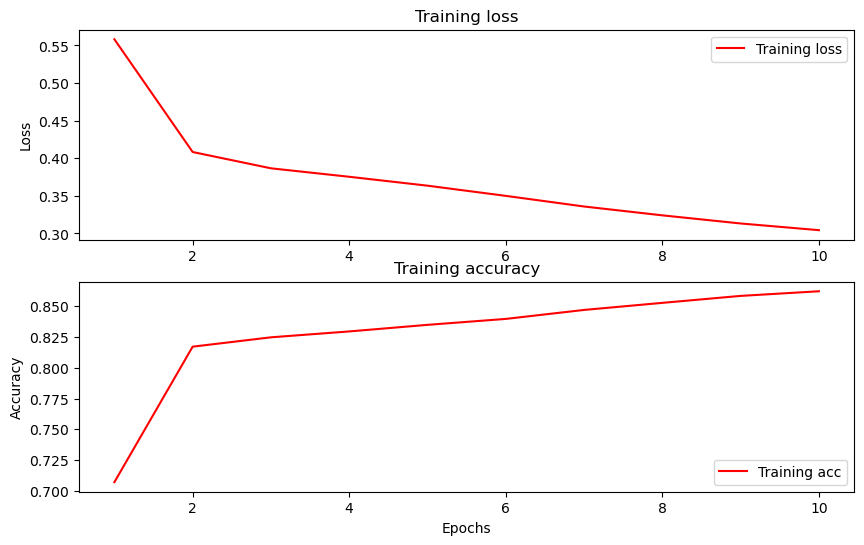

In [101]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [103]:
examples = [
    "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D", 
    "is upset that he can't update his Facebook by ...",
    '@Kenichan I dived many times for the ball. Man...',
    'my whole body feels itchy and like its on fire',
    "@nationwideclass no, it's not behaving at all...."
]

model(tf.constant(examples))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.88713735],
       [0.02196392],
       [0.9220184 ],
       [0.73778796],
       [0.08708605]], dtype=float32)>

In [ ]:
def emojiMask(sentence):
    sentenceEmojiMask = emoji.replace_emoji(sentence,
                        replace=lambda chars,
                        data_dict: chars.encode('ascii', 'namereplace').decode())
    return sentenceEmojiMask


example_filtered = [emojiMask(str(row)) for row in x_train]

## First approach

In [8]:
import tensorflow_text as tf_text

tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(x_train_emojimask)
test_tokens = tokenizer.tokenize(x_test_emojimask)

2024-04-23 22:41:55.270601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-23 22:41:55.270674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: HP-Pavilion
2024-04-23 22:41:55.270687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: HP-Pavilion
2024-04-23 22:41:55.270839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.54.15
2024-04-23 22:41:55.270881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.54.15
2024-04-23 22:41:55.270893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.54.15


In [9]:
from itertools import chain

def flattenChain(element):
    return list(chain.from_iterable(element))


flatten_train_tokens = list(set(flattenChain(train_tokens.to_list())))
flatten_test_tokens = list(set(flattenChain(test_tokens.to_list())))

In [10]:
def _CreateTable(vocab, num_oov=1):
    init = tf.lookup.KeyValueTensorInitializer(
        vocab,
        tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64),
        key_dtype=tf.string,
        value_dtype=tf.int64)
    return tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)

In [11]:
train_vocab = _CreateTable(flatten_train_tokens)
test_vocab = _CreateTable(flatten_test_tokens)

In [65]:
# tensor vector for model
def trainTensorSlice(xtrain,ytrain):
    x_tensor = tf.constant(xtrain)
    y_tensor = tf.constant(ytrain)
    dataset_tensor = tf.data.Dataset.from_tensor_slices((x_tensor,y_tensor)).batch(2)
    return dataset_tensor

train_ds = trainTensorSlice(x_train_emojimask,y_train_num)
test_ds = trainTensorSlice(x_test_emojimask,y_test_num)

In [66]:
def trainPreprocess(data, labels):
    tokenizer = tf_text.WhitespaceTokenizer()
    data = tokenizer.tokenize(data)
    data = data.merge_dims(-2,-1)
    ids = tf.ragged.map_flat_values(train_vocab.lookup, data)
    return (ids, labels)

def testPreprocess(data, labels):
    tokenizer = tf_text.WhitespaceTokenizer()
    data = tokenizer.tokenize(data)
    data = data.merge_dims(-2,-1)
    ids = tf.ragged.map_flat_values(test_vocab.lookup, data)
    return (ids, labels)

In [67]:
train_ds = train_ds.map(trainPreprocess)
test_ds = test_ds.map(testPreprocess)

In [68]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [63]:
reviews_data_array = ['I really liked this movie', 'not my favorite']
reviews_labels_array = [1,0]

train_x = tf.constant(reviews_data_array)
train_y = tf.constant(reviews_labels_array)

a = _CreateTable(['I', 'really', 'liked', 'this', 'movie', 'not', 'my', 'favorite'])

def preprocess(data, labels):
  t = tf_text.WhitespaceTokenizer()
  data = t.tokenize(data)
  # data = data.merge_dims(-2,-1)
  ids = tf.ragged.map_flat_values(a.lookup, data)
  return (ids, labels)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(2)
train_dataset = train_dataset.map(preprocess)

In [64]:
for e in train_dataset.take(1):
    print(e)

(<tf.RaggedTensor [[0, 1, 2, 3, 4], [5, 6, 7]]>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 0], dtype=int32)>)


2024-04-24 13:29:34.742706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype resource
	 [[{{node Placeholder/_6}}]]


In [38]:
def filter_dataset(tensor, nsplit=0, category_pos=0):
    split_tensor = tf.strings.split(tensor, ',', maxsplit=nsplit)
    sentiment_category = split_tensor[category_pos]

    return (True if sentiment_category != 'Irrelevant' else False)

In [39]:
# converting the data into tensor data using the filter
train_ds = tf.data.TextLineDataset('processed_twitter_train.csv').filter(selector_dataset)
test_ds = tf.data.TextLineDataset('processed_twitter_test.csv').filter(selector_dataset)

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [40]:
for e in train_ds.take(2):
    print(e)

tf.Tensor(b'2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"', shape=(), dtype=string)
tf.Tensor(b'2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"', shape=(), dtype=string)


2024-04-23 11:27:55.243632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [57]:
import json

# import the json file
with open('emoji-unicode.json') as json_file:
    emoji_dict= json.load(json_file)

# remove the unnecessary keys and values from the dictionary 
trash_keys = ['no',
              'emoji',
              'flagged',
              'keywords']

for trash_key in trash_keys:
    for _ in range(len(emoji_dict['emojis'])):
        emoji_dict['emojis'][_].pop(trash_key,None)

In [62]:
# processing the format to unicode
def format_to_unicode(s):
    code_point = int(s[2:], 16)
    return chr(code_point)

list_emoji_dict = emoji_dict['emojis']
len_list_emoji_dict = len(list_emoji_dict)
for _ in range(len_list_emoji_dict):
    for code, description in list_emoji_dict[_].items():
        emoji_uni = list_emoji_dict[_]['code']
        emoji_desc = list_emoji_dict[_]['description']
        df_train_ds['Comment'] = df_train_ds['Comment'].str.replace(format_to_unicode(emoji_uni), emoji_desc)
        df_test_ds['Comment'] = df_test_ds['Comment'].str.replace(format_to_unicode(emoji_uni), emoji_desc)

Once the dataset emoji mask is set, we can export the csv for including it into the general model. Indeed, if we want to, we can do the preprocessing job first including removing stoping words punctuation that might improve the performance in our model in this case.

In [63]:
#exporting the processed dataset into a csv file
df_train_ds.to_csv('processed_twitter_train.csv', index=False, header=False) 
df_test_ds.to_csv('processed_twitter_test.csv', index=False, header=False) 

In [68]:
for e in train_ds.skip(1).take(2):
    print(e)

tf.Tensor(b'2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"', shape=(), dtype=string)
tf.Tensor(b'2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"', shape=(), dtype=string)


2024-04-23 03:10:38.715556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [69]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [76]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [80]:
# build vocabulary and save it to vocabulary.obj
vocabulary = vectorize_layer.adapt(train_ds)
vocab_file = open('vocabulary.obj','wb')
pickle.dump(vocabulary,vocab_file)

In [ ]:
# # for loading the vocabulary
# vocab_file = open('vocabulary.obj','rb')
# vocabulary = pickle.load(vocab_file)


In [81]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label